# Power measure with Spectrum analyzer 8560A

In [8]:
import serial
import time
import pyvisa
import sys
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import clear_output
from datetime import datetime
import import_ipynb

#locals
import STM32_HCI

# Specify script parameters :

In [9]:
###############################
##Specify device COMPort#######
STM32ComPort = "COM8"
###############################

In [10]:
##################################################
##Specify power in dBm #######
power = 0
##################################################

In [11]:
###############################
##Specify SA GPIB address######
Spectrum = "GPIB0::0::0::INSTR"
###############################

In [12]:
###############################
##Spectrum capture parameters##
spectrumCenter = "2440000000"
spectrumSpan = "100000000"
spectrumRBW = "100000"
spectrumReferenceLevel = "10"
###############################

# Prepare peripherals :

In [13]:
#HP8560A
#Spectrum analyzer setup
rm = pyvisa.ResourceManager()
instrument = rm.open_resource(Spectrum)

# Configuration
instrument.write("CF " + spectrumCenter)  # Set central frequency to 2440 MHz
instrument.write("SP " + spectrumSpan)  # Set span to 80 MHz
instrument.write("RB " + spectrumRBW) # Set resolution bandwidth to 100kHz
instrument.write("RL " + spectrumReferenceLevel) #Set reference level to +10dB

7

In [14]:
serialPort = serial.Serial(port = STM32ComPort, baudrate = 115200, timeout = 3)

# Main function :

In [15]:
#logging table
df = pd.DataFrame(columns=range(41), index=range(601))

frequencies = range(int(spectrumCenter) - int(spectrumSpan)//2, int(spectrumCenter) + int(spectrumSpan)//2, int(spectrumSpan)//600)
df[0] = frequencies

STM32_HCI.StopTone(serialPort)
STM32_HCI.StopRxTx(serialPort)

STM32_HCI.SetTxPower(serialPort, 6)

for i in range(40):
    STM32_HCI.StartTone(serialPort,i)
    time.sleep(2)
    # Get Spectrum trace
    instrument.write("TRA?")
    trace_data = instrument.read()

    trace_data = trace_data[0:len(trace_data)-1]
    data = trace_data.split(",")
    df[i+1] = data

    STM32_HCI.StopTone(serialPort)
    
df = df.astype(float)

In [16]:
df.to_csv("file.csv")

In [17]:
df1 = df.set_index(0)

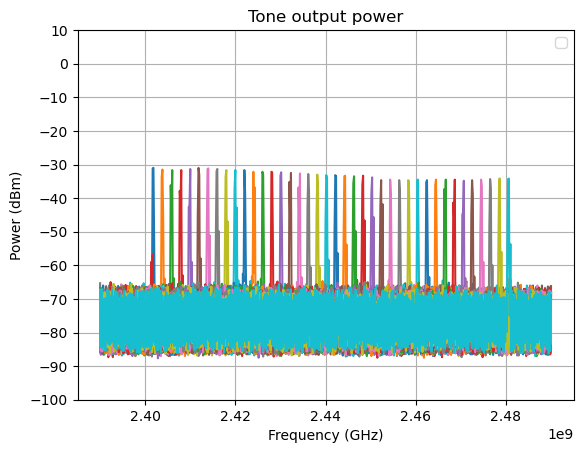

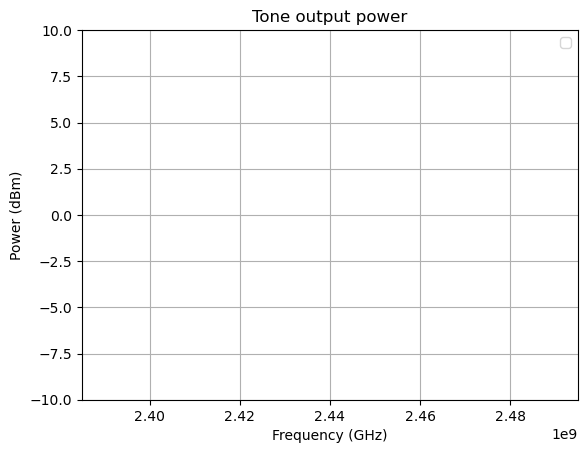

In [23]:
for col in df1.columns:
    plt.plot(df1.index, df1[col], label=f'Colonne {col}')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dBm)')
plt.title('Tone output power')
plt.legend()
plt.grid(True)
plt.yticks(range(-100, int(spectrumReferenceLevel)+10, 10))
plt.legend([])
plt.show()


for col in df1.columns:
    plt.plot(df1.index, df1[col], label=f'Colonne {col}')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dBm)')
plt.title('Tone output power')
plt.legend()
plt.grid(True)
plt.ylim(-10,10)
plt.legend([])
plt.show()

In [19]:
serialPort.close()